In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import colors
from matplotlib.widgets import Slider
import matplotlib
import matplotlib.font_manager

from medmnist import VesselMNIST3D
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Available devices:", tf.config.list_physical_devices())

TensorFlow version: 2.20.0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
from medmnist import VesselMNIST3D


In [7]:
train_dataset = VesselMNIST3D(split='train', size=28, download=True)
trainx = []
trainy = []

test_dataset = VesselMNIST3D(split='test', size=28, download=True)
testx = []
testy = []

val_dataset = VesselMNIST3D(split='val', size=28, download=True)  # Fixed: was 'train'
valx = []
valy = []

for i in range(len(train_dataset)):
    trainx.append(train_dataset[i][0])
    trainy.append(train_dataset[i][1])

for i in range(len(test_dataset)):
    testx.append(test_dataset[i][0])
    testy.append(test_dataset[i][1])

for i in range(len(val_dataset)):
    valx.append(val_dataset[i][0])
    valy.append(val_dataset[i][1])

trainx_tensor = tf.convert_to_tensor(trainx, dtype=tf.float32)  # Using float32 for now
trainy_tensor = tf.convert_to_tensor(trainy, dtype=tf.float32)
testx_tensor = tf.convert_to_tensor(testx, dtype=tf.float32)
testy_tensor = tf.convert_to_tensor(testy, dtype=tf.float32)
valx_tensor = tf.convert_to_tensor(valx, dtype=tf.float32)
valy_tensor = tf.convert_to_tensor(valy, dtype=tf.float32)

print(f"\nData loaded successfully!")
print(f"Training set: {trainx_tensor.shape}")
print(f"Validation set: {valx_tensor.shape}")
print(f"Test set: {testx_tensor.shape}")



Data loaded successfully!
Training set: (1335, 1, 28, 28, 28)
Validation set: (191, 1, 28, 28, 28)
Test set: (382, 1, 28, 28, 28)


In [8]:
%matplotlib notebook
%matplotlib inline 

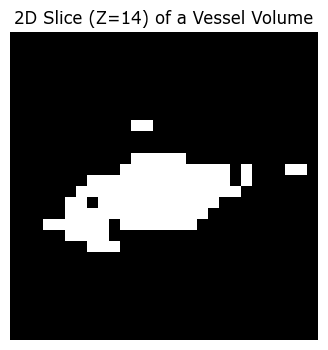

In [9]:

sample_volume = trainx_tensor[0].numpy().squeeze()

slice_index = sample_volume.shape[0] // 2 
image_slice = sample_volume[slice_index, :, :]

plt.figure(figsize=(4, 4))
plt.imshow(image_slice, cmap='gray')
plt.title(f'2D Slice (Z={slice_index}) of a Vessel Volume')
plt.axis('off')
plt.show() 


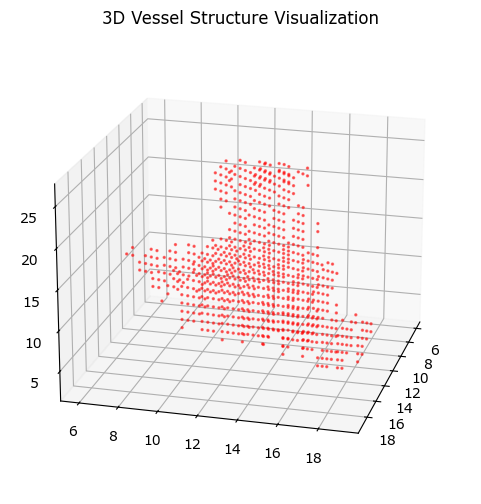

In [10]:
x, y, z = np.where(sample_volume > 0)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d') 

ax.scatter(x, y, z, s=2, c='red', alpha=0.5)

ax.set_title('3D Vessel Structure Visualization')
ax.view_init(elev=20, azim=15)

plt.show()

Training - Class 0 (Healthy): 1185, Class 1 (Aneurysm): 150
Validation - Class 0 (Healthy): 169, Class 1 (Aneurysm): 22
Test - Class 0 (Healthy): 339, Class 1 (Aneurysm): 43

Class imbalance ratio (train): 0.127


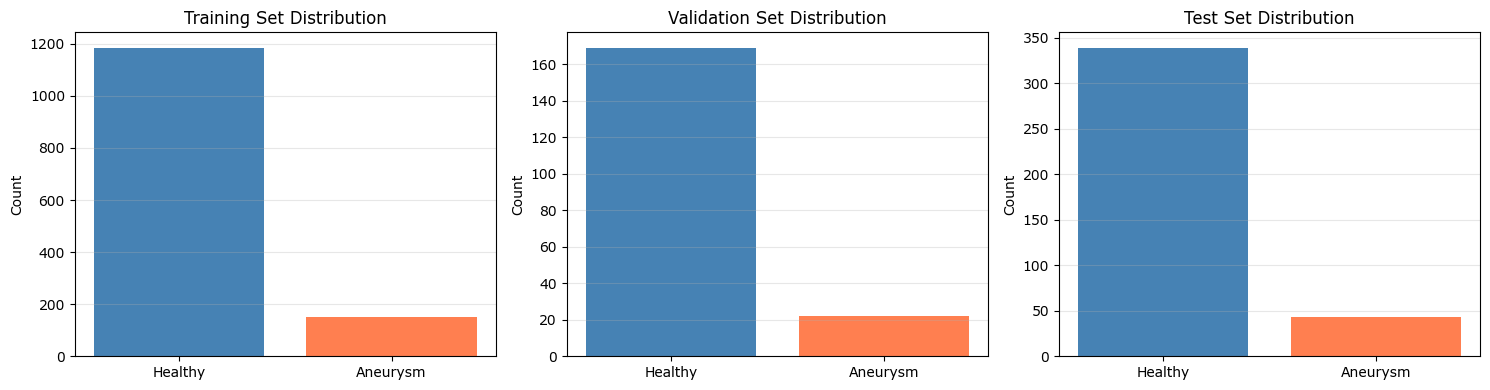

In [11]:
#Analyze class distribution
train_labels = np.array(trainy).flatten()
val_labels = np.array(valy).flatten()
test_labels = np.array(testy).flatten()

unique_train, counts_train = np.unique(train_labels, return_counts=True)
unique_val, counts_val = np.unique(val_labels, return_counts=True)
unique_test, counts_test = np.unique(test_labels, return_counts=True)

print(f"Training - Class 0 (Healthy): {counts_train[0]}, Class 1 (Aneurysm): {counts_train[1]}")
print(f"Validation - Class 0 (Healthy): {counts_val[0]}, Class 1 (Aneurysm): {counts_val[1]}")
print(f"Test - Class 0 (Healthy): {counts_test[0]}, Class 1 (Aneurysm): {counts_test[1]}")
print(f"\nClass imbalance ratio (train): {counts_train[1]/counts_train[0]:.3f}")

# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, counts) in zip(axes, 
    [('Training', counts_train), ('Validation', counts_val), ('Test', counts_test)]):
    ax.bar(['Healthy', 'Aneurysm'], counts, color=['steelblue', 'coral'])
    ax.set_ylabel('Count')
    ax.set_title(f'{name} Set Distribution')
    ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

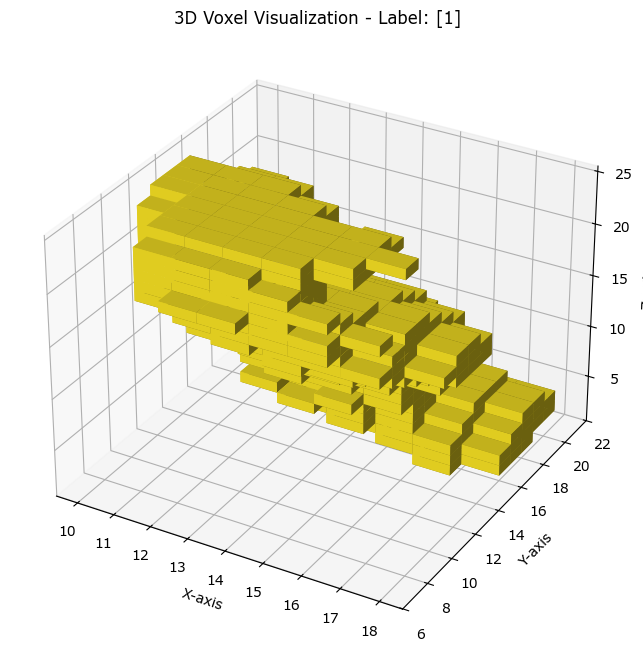

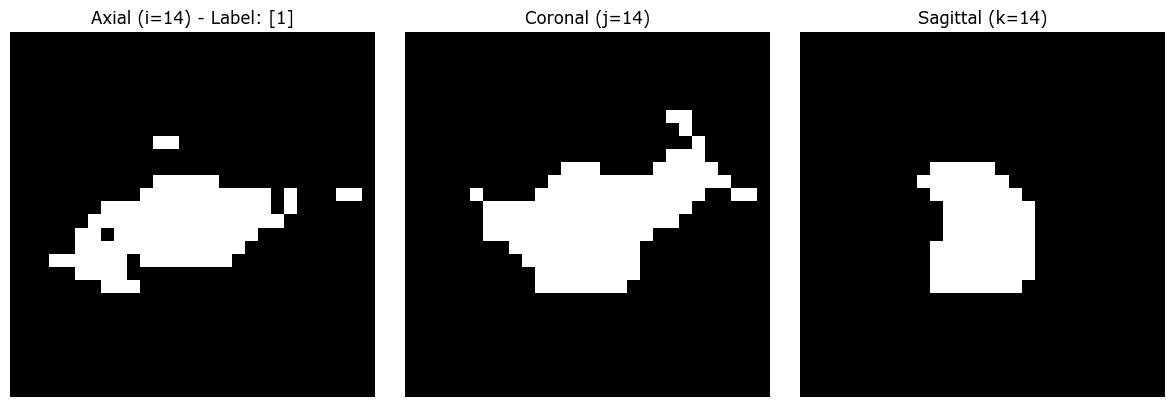

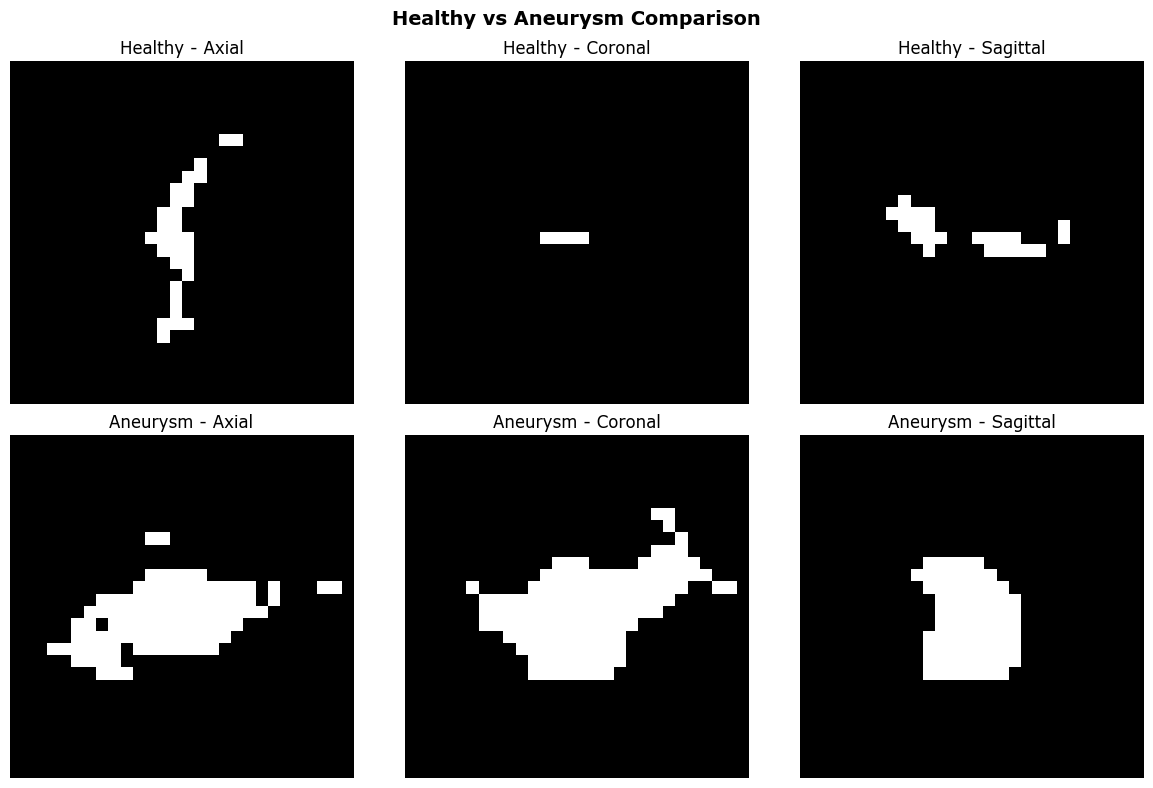

In [12]:
# Example 1: 3D Voxel Visualization
fig = plt.figure(figsize=(10, 8))
vol = np.squeeze(trainx[1], axis=0)  # shape (28, 28, 28)
ax = fig.add_subplot(111, projection='3d')

filled = vol > 0
norm = colors.Normalize(vmin=vol.min(), vmax=vol.max())
cmap = plt.cm.viridis
facecolors = cmap(norm(vol))
alpha = np.clip(vol, 0, 1)
facecolors[..., 3] = alpha
facecolors[~filled, 3] = 0.0

ax.voxels(filled, facecolors=facecolors)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.title(f'3D Voxel Visualization - Label: {trainy[1]}')
plt.show()

# Example 2: Orthogonal Slices (Middle Slices)
vol = np.array(trainx[0]).squeeze()
i_mid = vol.shape[0] // 2
j_mid = vol.shape[1] // 2
k_mid = vol.shape[2] // 2

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(vol[i_mid, :, :], cmap='gray')
axes[0].set_title(f'Axial (i={i_mid}) - Label: {trainy[0]}')
axes[0].axis('off')

axes[1].imshow(vol[:, j_mid, :], cmap='gray')
axes[1].set_title(f'Coronal (j={j_mid})')
axes[1].axis('off')

axes[2].imshow(vol[:, :, k_mid], cmap='gray')
axes[2].set_title(f'Sagittal (k={k_mid})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Example 3: Show healthy vs aneurysm examples
healthy_idx = np.where(train_labels == 0)[0][0]
aneurysm_idx = np.where(train_labels == 1)[0][0]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.suptitle('Healthy vs Aneurysm Comparison', fontsize=14, fontweight='bold')

# Healthy example
vol_healthy = np.array(trainx[healthy_idx]).squeeze()
mid = vol_healthy.shape[0] // 2
axes[0, 0].imshow(vol_healthy[mid, :, :], cmap='gray')
axes[0, 0].set_title('Healthy - Axial')
axes[0, 0].axis('off')
axes[0, 1].imshow(vol_healthy[:, mid, :], cmap='gray')
axes[0, 1].set_title('Healthy - Coronal')
axes[0, 1].axis('off')
axes[0, 2].imshow(vol_healthy[:, :, mid], cmap='gray')
axes[0, 2].set_title('Healthy - Sagittal')
axes[0, 2].axis('off')

# Aneurysm example
vol_aneurysm = np.array(trainx[aneurysm_idx]).squeeze()
mid = vol_aneurysm.shape[0] // 2
axes[1, 0].imshow(vol_aneurysm[mid, :, :], cmap='gray')
axes[1, 0].set_title('Aneurysm - Axial')
axes[1, 0].axis('off')
axes[1, 1].imshow(vol_aneurysm[:, mid, :], cmap='gray')
axes[1, 1].set_title('Aneurysm - Coronal')
axes[1, 1].axis('off')
axes[1, 2].imshow(vol_aneurysm[:, :, mid], cmap='gray')
axes[1, 2].set_title('Aneurysm - Sagittal')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


In [18]:
# From (1335, 1, 28, 28, 28) to (1335, 28, 28, 28, 1)
trainx_tensor = tf.transpose(trainx_tensor, [0, 2, 3, 4, 1])
valx_tensor = tf.transpose(valx_tensor, [0, 2, 3, 4, 1])
testx_tensor = tf.transpose(testx_tensor, [0, 2, 3, 4, 1])

print(f"After transpose - Training data shape: {trainx_tensor.shape}")

# Normalize data to [0, 1] range
trainx_norm = trainx_tensor / 255.0
valx_norm = valx_tensor / 255.0
testx_norm = testx_tensor / 255.0

# Flatten labels
trainy_flat = tf.squeeze(trainy_tensor)
valy_flat = tf.squeeze(valy_tensor)
testy_flat = tf.squeeze(testy_tensor)

print(f"Normalized training data shape: {trainx_norm.shape}")
print(f"Training labels shape: {trainy_flat.shape}")
print(f"Data range: [{tf.reduce_min(trainx_norm):.3f}, {tf.reduce_max(trainx_norm):.3f}]")

# Calculate class weights for imbalanced data
class_weight = {
    0: float(len(train_labels) / (2 * counts_train[0])),
    1: float(len(train_labels) / (2 * counts_train[1]))
}
print(f"\nClass weights to handle imbalance: {class_weight}")



After transpose - Training data shape: (1335, 1, 28, 28, 28)
Normalized training data shape: (1335, 1, 28, 28, 28)
Training labels shape: (1335,)
Data range: [0.000, 0.004]

Class weights to handle imbalance: {0: 0.5632911392405063, 1: 4.45}


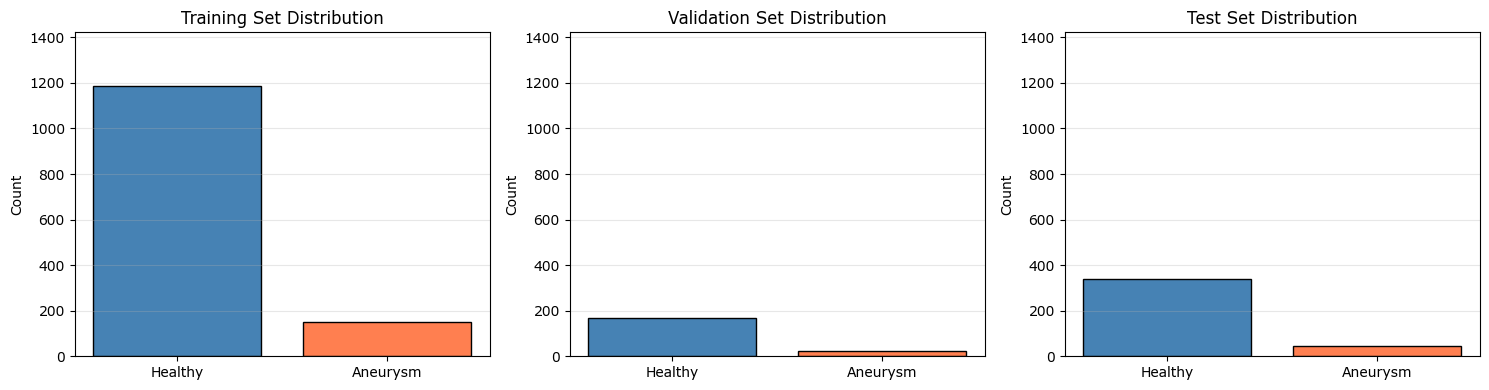

In [16]:
# Ensure counts are lists/arrays, not tensors
train_counts = [int(counts_train[0]), int(counts_train[1])]
val_counts   = [int(counts_val[0]), int(counts_val[1])]
test_counts  = [int(counts_test[0]), int(counts_test[1])]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

datasets = [
    ("Training", train_counts),
    ("Validation", val_counts),
    ("Test", test_counts)
]

for ax, (name, counts) in zip(axes, datasets):
    ax.bar(
        ['Healthy', 'Aneurysm'],
        counts,
        color=['steelblue', 'coral'],
        edgecolor='black'
    )
    ax.set_title(f'{name} Set Distribution')
    ax.set_ylabel('Count')
    ax.set_ylim(0, max(train_counts + val_counts + test_counts) * 1.2)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [5]:
# Load data
train_dataset = VesselMNIST3D(split='train', size=28, download=True)
val_dataset = VesselMNIST3D(split='val', size=28, download=True)
test_dataset = VesselMNIST3D(split='test', size=28, download=True)

trainx = np.array([train_dataset[i][0] for i in range(len(train_dataset))])
trainy = np.array([train_dataset[i][1][0] for i in range(len(train_dataset))])

valx = np.array([val_dataset[i][0] for i in range(len(val_dataset))])
valy = np.array([val_dataset[i][1][0] for i in range(len(val_dataset))])

testx = np.array([test_dataset[i][0] for i in range(len(test_dataset))])
testy = np.array([test_dataset[i][1][0] for i in range(len(test_dataset))])

print(f"Train X shape: {trainx.shape}, Train y shape: {trainy.shape}")
print(f"Val X shape: {valx.shape}, Val y shape: {valy.shape}")
print(f"Test X shape: {testx.shape}, Test y shape: {testy.shape}")

# Class distribution
n_class0 = np.sum(trainy == 0)
n_class1 = np.sum(trainy == 1)
print(f"\nClass distribution - Class 0: {n_class0}, Class 1: {n_class1}")
print(f"Imbalance ratio: {n_class0 / n_class1:.1f}:1")

Train X shape: (1335, 1, 28, 28, 28), Train y shape: (1335,)
Val X shape: (191, 1, 28, 28, 28), Val y shape: (191,)
Test X shape: (382, 1, 28, 28, 28), Test y shape: (382,)

Class distribution - Class 0: 1185, Class 1: 150
Imbalance ratio: 7.9:1
